In [1]:
import torch
from torch import nn
import torch.utils.data as Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from model import Classifier
from preprocessing import Create_Matrix, StandardScaler, Split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
timesteps = 90
batch_size = 512

In [3]:
data = pd.read_csv('bdi.csv', parse_dates=['date'], index_col=['date']).fillna(method='ffill').values

In [4]:
x, y = Create_Matrix(data, timesteps)
x_train, y_train, x_val, y_val, x_test, y_test = Split(x, y)

In [5]:
scaler = StandardScaler(y_train)
y_train = scaler.transform(y_train)
x_train = scaler.transform(x_train)
y_val = scaler.transform(y_val)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [6]:
x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
x_val = torch.FloatTensor(x_val).to(device)
y_val = torch.FloatTensor(y_val).to(device)
x_test = torch.FloatTensor(x_test).to(device)

In [7]:
dataset = Data.TensorDataset(x_train, y_train)
dataloader = Data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [12]:
model = Classifier().to(device)
print(model)

adam = torch.optim.Adam(model.parameters(), lr=0.01)
sgd = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

Classifier(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [14]:
model.sigmoid = nn.Sequential()

In [15]:
epochs = 200
history = dict()
history['loss'] = []
history['val_loss'] = []
best_model = np.inf
for epoch in range(epochs):
    for x_batch, y_batch in dataloader:
        model.train()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        adam.zero_grad()
        loss.backward()
        adam.step()
    with torch.no_grad():
        model.eval()
        y_pred = model(x_val)
        val_loss = criterion(y_pred, y_val)
        loss = loss.item()
        val_loss = val_loss.item()
    print(f'Epoch:{1+epoch:03d}-loss:{loss:.5f}-val_loss:{val_loss:.5f}')
    if val_loss <= best_model:
        best_model = val_loss
        torch.save(model, 'checkpoint.pt')
        print('weight_saved')
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
model = torch.load('checkpoint.pt')

Epoch:001-loss:0.16509-val_loss:0.11714
weight_saved
Epoch:002-loss:0.01658-val_loss:0.00195
weight_saved
Epoch:003-loss:0.00547-val_loss:0.00153
weight_saved
Epoch:004-loss:0.00375-val_loss:0.00165
Epoch:005-loss:0.00198-val_loss:0.00097
weight_saved
Epoch:006-loss:0.00143-val_loss:0.00090
weight_saved
Epoch:007-loss:0.00136-val_loss:0.00047
weight_saved
Epoch:008-loss:0.00146-val_loss:0.00042
weight_saved
Epoch:009-loss:0.00184-val_loss:0.00042
weight_saved
Epoch:010-loss:0.00170-val_loss:0.00042
Epoch:011-loss:0.00163-val_loss:0.00037
weight_saved
Epoch:012-loss:0.00129-val_loss:0.00044
Epoch:013-loss:0.00111-val_loss:0.00048
Epoch:014-loss:0.00072-val_loss:0.00038
Epoch:015-loss:0.00141-val_loss:0.00034
weight_saved
Epoch:016-loss:0.00084-val_loss:0.00031
weight_saved
Epoch:017-loss:0.00163-val_loss:0.00034
Epoch:018-loss:0.00092-val_loss:0.00034
Epoch:019-loss:0.00136-val_loss:0.00035
Epoch:020-loss:0.00101-val_loss:0.00028
weight_saved
Epoch:021-loss:0.00075-val_loss:0.00047
Epoc

Epoch:194-loss:0.00034-val_loss:0.00007
Epoch:195-loss:0.00069-val_loss:0.00008
Epoch:196-loss:0.00043-val_loss:0.00010
Epoch:197-loss:0.00074-val_loss:0.00017
Epoch:198-loss:0.00040-val_loss:0.00009
Epoch:199-loss:0.00031-val_loss:0.00014
Epoch:200-loss:0.00025-val_loss:0.00012


In [16]:
with torch.no_grad():
    model.eval()
    pred = model(x_test)
    pred = pred.cpu().numpy()
    pred = scaler.inverse_transform(pred)

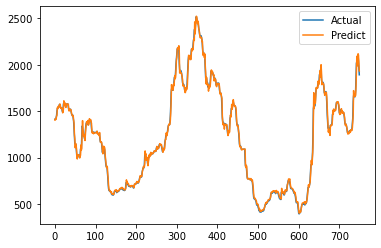

In [17]:
plt.plot(y_test, label='Actual')
plt.plot(pred, label='Predict')
plt.legend()
plt.show()

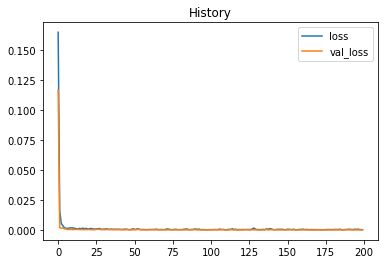

In [18]:
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.title('History')
plt.legend()
plt.show()

In [19]:
print(metrics.mean_absolute_error(pred, y_test))

18.0769140625
